In [1]:
!pip install crowd-kit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson
from collections import Counter
from crowdkit.aggregation import DawidSkene, MajorityVote

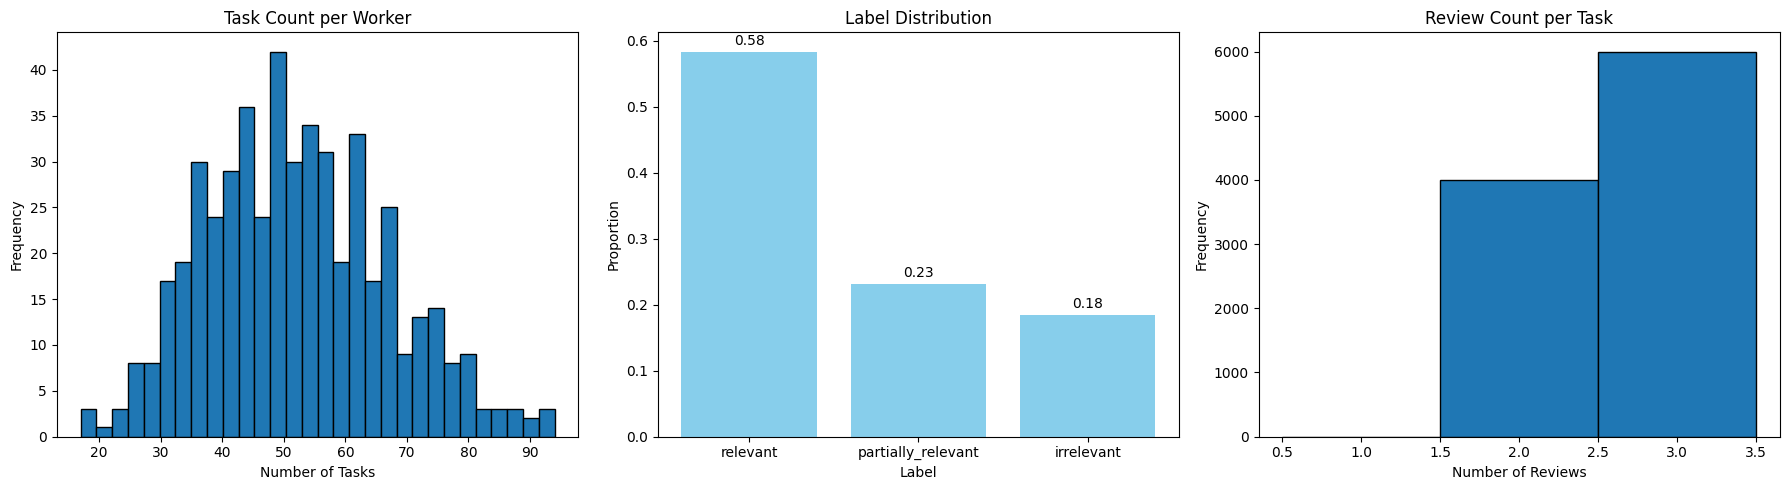

In [3]:
np.random.seed(42)

# Dataset Generation
num_tasks = 10000
num_workers = 500

# Labels and their distribution
labels = ['relevant', 'partially_relevant', 'irrelevant']
label_distribution = [0.7, 0.2, 0.1]

# Task coverage settings
overlap_3_ratio = 0.6
overlap_2_ratio = 0.4

# Generate credibility scores for workers
worker_credibility = np.random.rand(num_workers) * 0.5 + 0.5

# Generate worker task count distribution (Poisson distribution)
worker_task_counts = poisson.rvs(mu=20, size=num_workers)
worker_task_counts = np.clip(worker_task_counts, 1, 50)

# Data generation function with type hints
def generate_tasks(
    num_tasks: int,
    overlap: list[int],
    labels: list[str],
    label_distribution: list[float],
    worker_credibility: np.ndarray,
    worker_task_counts: np.ndarray
) -> pd.DataFrame:
    tasks = np.repeat(np.arange(num_tasks), overlap)
    workers = []
    labels_assigned = []

    for task_id in range(num_tasks):
        num_assessors = overlap[task_id]
        assigned_workers = np.random.choice(
            num_workers,
            size=num_assessors,
            replace=False,
            p=worker_task_counts / worker_task_counts.sum()
        )

        # Ensure some tasks have consistent labels, while others have disagreements
        task_labels = []
        if np.random.rand() < 0.8:
            main_label = np.random.choice(labels, p=label_distribution)
            task_labels = [main_label] * num_assessors
        else:
            task_labels = np.random.choice(labels, num_assessors, p=label_distribution)

        for i, worker in enumerate(assigned_workers):
            workers.append(worker)
            # Adjust label selection based on worker credibility
            if worker_credibility[worker] > 0.8:
                labels_assigned.append(task_labels[i])
            else:
                noise_distribution = [0.5, 0.25, 0.25]
                labels_assigned.append(np.random.choice(labels, p=noise_distribution))

    return pd.DataFrame({
        'task': tasks,
        'worker': workers,
        'label': labels_assigned
    })

# Generate data: some tasks have 2 workers, some have 3 workers
overlap = [3] * int(num_tasks * overlap_3_ratio) + [2] * int(num_tasks * overlap_2_ratio)
data = generate_tasks(num_tasks, overlap, labels, label_distribution, worker_credibility, worker_task_counts)

# Data Visualization and Analysis function with type hints
def visualize_distributions(data: pd.DataFrame) -> None:
    task_count_per_worker = data['worker'].value_counts()
    label_distribution_actual = data['label'].value_counts(normalize=True)
    task_overlap_distribution = data['task'].value_counts()

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Distribution of tasks per worker
    axes[0].hist(task_count_per_worker, bins=30, edgecolor='black')
    axes[0].set_title('Task Count per Worker')
    axes[0].set_xlabel('Number of Tasks')
    axes[0].set_ylabel('Frequency')

    # Label distribution
    axes[1].bar(label_distribution_actual.index, label_distribution_actual.values, color='skyblue')
    axes[1].set_title('Label Distribution')
    axes[1].set_xlabel('Label')
    axes[1].set_ylabel('Proportion')
    for i, v in enumerate(label_distribution_actual.values):
        axes[1].text(i, v + 0.01, f"{v:.2f}", ha='center')

    # Distribution of review counts per task
    axes[2].hist(task_overlap_distribution, bins=range(1, 5), edgecolor='black', align='left')
    axes[2].set_title('Review Count per Task')
    axes[2].set_xlabel('Number of Reviews')
    axes[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

visualize_distributions(data)

# Aggregation Algorithm Analysis function with type hints
def aggregate_labels(data: pd.DataFrame) -> tuple[pd.Series, pd.Series]:
    mv = MajorityVote()
    ds = DawidSkene()
    mv_result = mv.fit_predict(data)
    ds_result = ds.fit_predict(data)
    return mv_result, ds_result

# Perform aggregation
mv_result, ds_result = aggregate_labels(data)

# Analyzing Differences in Aggregation Results
results = pd.DataFrame({
    'task': data['task'].unique(),
    'MajorityVote': mv_result.values,
    'DawidSkene': ds_result.values
}).reset_index(drop=True)

# Find disagreements in  results
disagreements = results[results['MajorityVote'] != results['DawidSkene']]

**Based on the real distribution, there is usually a ‘long-tail effect’ in the distribution, i.e., most of the results are relevant or partially relevant, while a small portion is completely irrelevant.**

In [4]:
# Find the most common disagreement pattern
def find_most_common_disagreement_pattern(disagreements: pd.DataFrame, data: pd.DataFrame) -> tuple:
    patterns = []

    for i, row in disagreements.iterrows():
        task_id = row['task']
        task_data = data[data['task'] == task_id]

        # Count the label distribution for each task
        label_counts = tuple(task_data['label'].value_counts())
        patterns.append(label_counts)

    # Calculate the most frequent pattern
    pattern_counts = Counter(patterns)
    most_common_pattern = pattern_counts.most_common(1)[0]

    print(f"The most common disagreement pattern is: {most_common_pattern[0]}, which appeared {most_common_pattern[1]} times")
    return most_common_pattern[0]


# Filter tasks based on the most common disagreement pattern
def filter_disagreements_by_pattern(
    disagreements: pd.DataFrame,
    data: pd.DataFrame,
    pattern: tuple
) -> list:
    filtered_cases = []

    for i, row in disagreements.iterrows():
        task_id = row['task']
        task_data = data[data['task'] == task_id]

        # Check if the task's label distribution matches the most common disagreement pattern
        label_counts = tuple(task_data['label'].value_counts())
        if label_counts == pattern:
            majority_label = row['MajorityVote']
            dawid_label = row['DawidSkene']
            filtered_cases.append((task_id, task_data, majority_label, dawid_label))

    return filtered_cases

# Filter out tasks that match a specific disagreement pattern
filtered_disagreements = filter_disagreements_by_pattern(disagreements, data, (2, 1))

# Analyze the reason for Dawid-Skene choosing the minority opinion
def analyze_dawid_selection_reason(
    filtered_disagreements: list,
    worker_credibility: np.ndarray
) -> None:
    print("\nAnalysis of tasks where Dawid-Skene chose the minority opinion:")

    for task_id, task_data, majority_label, dawid_label in filtered_disagreements:
        workers = task_data['worker'].unique()
        task_credibility = worker_credibility[workers]

        print(f"\nDetailed information for task {task_id}:")
        print(task_data)
        print("Credibility of workers:", task_credibility)
        print(f"Majority Vote choice: {majority_label}, Dawid-Skene choice: {dawid_label}")

        # Check if there is a worker with the label chosen by Dawid-Skene as the minority opinion
        minority_data = task_data[task_data['label'] == dawid_label]
        if minority_data.empty:
            print("No worker found with the label chosen by Dawid-Skene as the minority opinion.\n")
            continue

        # Find the ID and credibility of the minority worker
        minority_worker = minority_data['worker'].values[0]
        minority_credibility = worker_credibility[minority_worker]
        print(f"Reason for Dawid-Skene choosing the minority opinion: Worker {minority_worker} has higher credibility ({minority_credibility})\n")

# Call the analysis function
analyze_dawid_selection_reason(filtered_disagreements, worker_credibility)

流式输出内容被截断，只能显示最后 5000 行内容。

Detailed information for task 2483:
      task  worker               label
7449  2483     243  partially_relevant
7450  2483     374            relevant
7451  2483     144            relevant
Credibility of workers: [0.68507935 0.53559432 0.64242025]
Majority Vote choice: relevant, Dawid-Skene choice: irrelevant
No worker found with the label chosen by Dawid-Skene as the minority opinion.


Detailed information for task 2487:
      task  worker       label
7461  2487     188  irrelevant
7462  2487     362  irrelevant
7463  2487      40    relevant
Credibility of workers: [0.76482529 0.72912645 0.56101912]
Majority Vote choice: irrelevant, Dawid-Skene choice: relevant
Reason for Dawid-Skene choosing the minority opinion: Worker 40 has higher credibility (0.5610191174223894)


Detailed information for task 2489:
      task  worker               label
7467  2489     374          irrelevant
7468  2489     259  partially_relevant
7469  2489      42          irrel

MajorityVote tends to favour the opinions of the majority of reviewers, while Dawid-Skene sometimes selects minority labels based on the credibility of the reviewers.

So in these cases, we observe a similar pattern of disagreement: two workers choose the same label, and another chooses a different label.Dawid-Skene both exhibit a clear pattern The algorithm prefers the opinions of high-credibility reviewers rather than simply relying on a voting majority.

So, the Dawid-Skene algorithm weights the labelling judgments of different workers according to their credibility. Even though the majority of workers chose the same label, the Dawid-Skene algorithm perceived a minority of labelled workers as having higher credibility, and therefore assigned a higher weight to that label.

There is also the fact that the choice of labels is not a simple voting majority decision. Instead, the algorithm adjusts the importance of each worker's label based on the accuracy of their historical judgement of the label